In [1]:
import os, warnings
from pathlib import Path

import anndata as ad
import numpy as np
import dynamo as dyn
import spateo as st
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

2023-09-01 01:23:10.669087: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 01:23:10.690468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 01:23:11.020220: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
from pyvista import PolyData, UniformGrid, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid, UniformGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

## Load the data

In [3]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_{sample_id}_germ_layer")
cpo = [(278, 1174, 131), (13, 8, -3), (0, 0, 1)]

out_image_path = f"image/morphofield_germ_layer/migration_region_cci"
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [68]:
germ_adata = st.read_h5ad(f"h5ad/{sample_id}_germ_layer_high_acceleration_v4.h5ad")
germ_adata.obs = germ_adata.obs[['area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new']]
align_spatial = germ_adata.obsm["3d_align_spatial"]
del germ_adata.obsm, germ_adata.uns
germ_adata.obsm["3d_align_spatial"] = align_spatial

tissue_adata = st.read_h5ad(f"h5ad/{sample_id}_mapping_amnioserosa.h5ad")
align_spatial = tissue_adata.obsm["tdr_spatial"]
del tissue_adata.obsm, tissue_adata.uns
tissue_adata.obsm["3d_align_spatial"] = align_spatial

germ_adata = ad.concat([germ_adata, tissue_adata], join="outer", fill_value=0)
germ_adata = germ_adata[:, ~germ_adata.var.index.map(lambda x: str(x).startswith("RpS"))]
germ_adata = germ_adata[:, ~germ_adata.var.index.map(lambda x: str(x).startswith("RpL"))]
germ_adata = germ_adata[:, ~germ_adata.var.index.map(lambda x: str(x).startswith("mt:"))]
germ_adata.uns["__type"] = "UMI"

germ_adata.X = germ_adata.layers["X_counts"]
germ_adata = germ_adata[germ_adata.X.sum(axis=1) !=0, germ_adata.X.sum(axis=0) !=0]
sc.pp.normalize_total(germ_adata)
sc.pp.log1p(germ_adata)

germ_pc,_ = st.tdr.construct_pc(germ_adata, spatial_key="3d_align_spatial", groupby="anno_tissue_new", key_added="tissue")
germ_adata

AnnData object with n_obs × n_vars = 5033 × 7893
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z'
    uns: '__type', 'log1p'
    obsm: '3d_align_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## CCI

In [69]:
weights_graph, distance_graph, adata = st.tl.weighted_spatial_graph(
    germ_adata,
    spatial_key="3d_align_spatial",
    n_neighbors=10,
    fixed='n_neighbors',
)

|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> <insert> spatial_weights to obsp in AnnData Object.


|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> <insert> spatial_weights to obsp in AnnData Object.
|-----> 
--- 5 labels, 5033 samples ---
initalized (6,) index ptr: [0 0 0 0 0 0]
initalized (5033,) indices: [0 0 0 ... 0 0 0]
initalized (5033,) data: [1 1 1 ... 1 1 1]

|-----> Deep copying AnnData object and working on the new copy. Original AnnData object will not be modified.
|-----> Matrix multiplying labels x weights x labels-transpose, shape (5, 5033) x (5033, 5033) x (5033, 5).


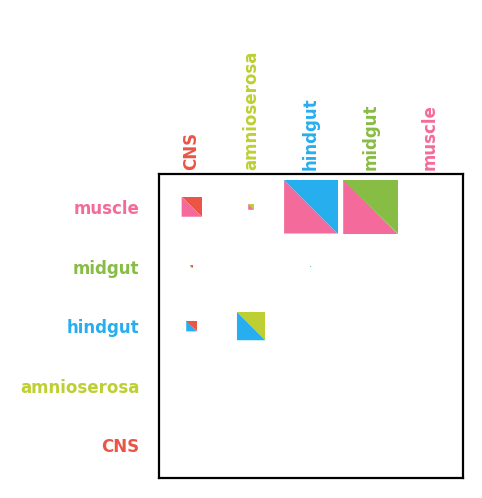

In [70]:
fig = st.pl.plot_connections(
    adata,
    cat_key='anno_tissue_new',
    spatial_key="3d_align_spatial",
    save_show_or_return='return',
    colormap={"CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "amnioserosa": "#bdcf32",},
    title_str=" ",
    title_fontsize=6,
    label_fontsize=6,
    figsize=(4, 2),
)
plt.savefig(os.path.join(out_image_path, f"{sample_id}_germ_layer_hc_cci_tissue_connections.pdf"), dpi=300, format="pdf", bbox_inches="tight")

## Amnioserosa and hindgut

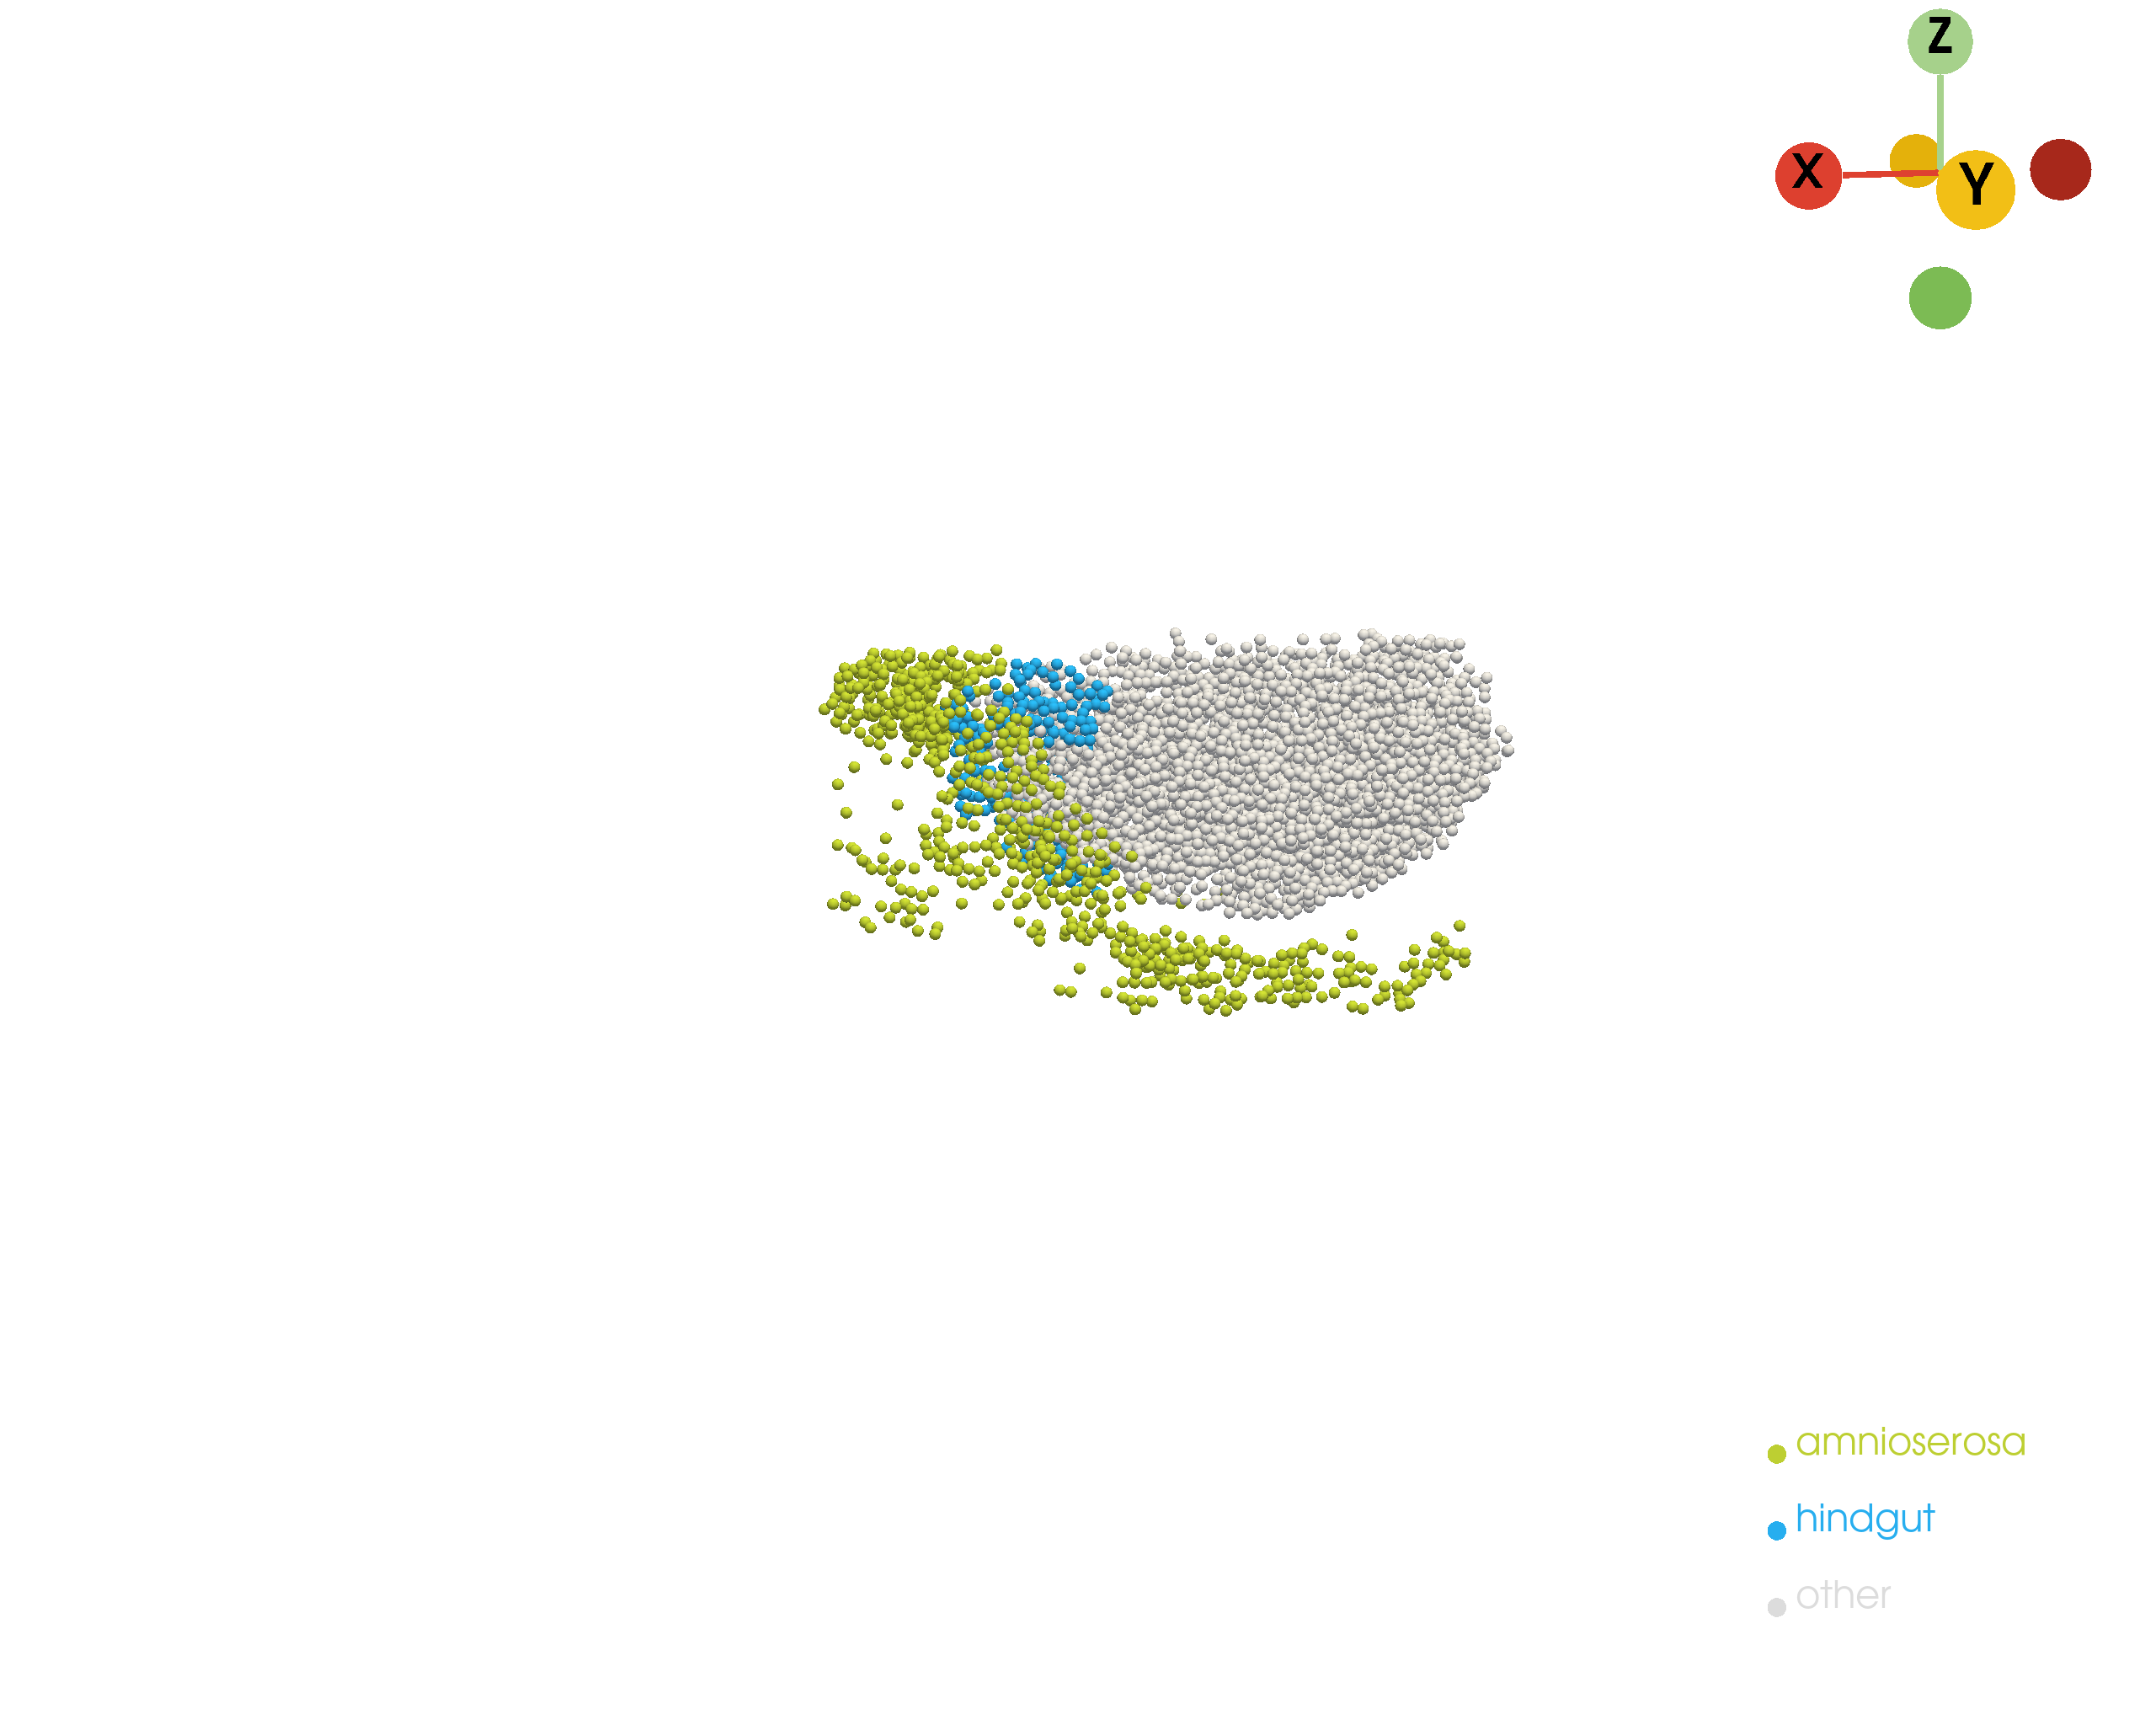

In [71]:
sender_ct, receptor_ct = "amnioserosa", "hindgut"
st.tl.prepare_cci_cellpair_adata(
    adata, sender_group=sender_ct, receiver_group=receptor_ct, group='anno_tissue_new', all_cell_pair=True
)
# plot all cell pair
pc_index=germ_pc.point_data["obs_index"].tolist()
mmvalue = adata[pc_index, :].obs["spec"].values
st.tdr.add_model_labels(model=germ_pc, labels=mmvalue, key_added="spec", where="point_data",inplace=True, colormap={"hindgut": "#27aeef", "amnioserosa": "#bdcf32", 'other': 'gainsboro'})
    
st.pl.three_d_plot(
    model=germ_pc,
    key="spec",
    model_style="points",
    model_size=14,
    opacity=1,
    show_legend=True,
    jupyter="static",
    background="white",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}.pdf")
)


In [77]:
res = st.tl.find_cci_two_group(adata,
                               path="/home/pc001/BioProjects/Packages/spateo-release/spateo/tools/database/",
                               species='drosophila',
                               group='anno_tissue_new',
                               sender_group=sender_ct,
                               receiver_group=receptor_ct,
                               filter_lr='outer',
                               mode="mode2",
                               fdr=True,
                               min_pairs=0,
                               min_pairs_ratio=0,
                               top=50,)

|-----> 50 ligands for cell type amnioserosa_prox with highest fraction of prevalence: ['Cad74A', 'orb2', 'Msr-110', 'tej', 'Vti1a', 'Myd88', 'SH3PX1', 'mdlc', 'ex', 'mtDNA-helicase', 'GlyP', 'Tsp3A', 'mTerf3', 'CG4611', 'knrl', 'wg', 'olf186-F', 'Pi3K68D', 'ksr', 'Su(H)', 'Pez', 'sky', 'rush', 'CG15211', 'elB', 'Blos4', 'ema', 'disco', 'GstE5', 'disp', 'CG10939', 'ASPP', 'CG10435', 'Ppcs', 'GstE8', 'tws', 'crb', 'Osbp', 'Nc73EF', 'Hex-A', 'NELF-B', 'GATAd', 'Cad99C', 'Fak', 'Blimp-1', 'cal1', 'Paip2', 'Ect4', 'Sym', 'CASK']. Testing interactions involving these genes.
|-----> 50 receptors for cell type hindgut_prox with highest fraction of prevalence: ['sip1', 'otp', 'hep', 'Rbsn-5', 'Tailor', 'CYLD', 'Shawn', 'mv', 'CG31098', 'l(2)gd1', 'Kap3', 'tun', 'SamDC', 'mib1', 'Uba3', 'CG10237', 'CG10939', 'Keap1', 'CG2064', 'Gsc', 'gsb-n', 'wbl', 'CG18789', 'pll', 'Strn-Mlck', 'CG10209', 'CG4908', 'GlyP', 'CG3645', 'CG8281', 'cu', 'Su(z)2', 'Buffy', 'ash1', 'Uvrag', 'Miro', 'Fhos', 'CG7778',

100%|██████████| 1000/1000 [00:03<00:00, 281.14it/s]


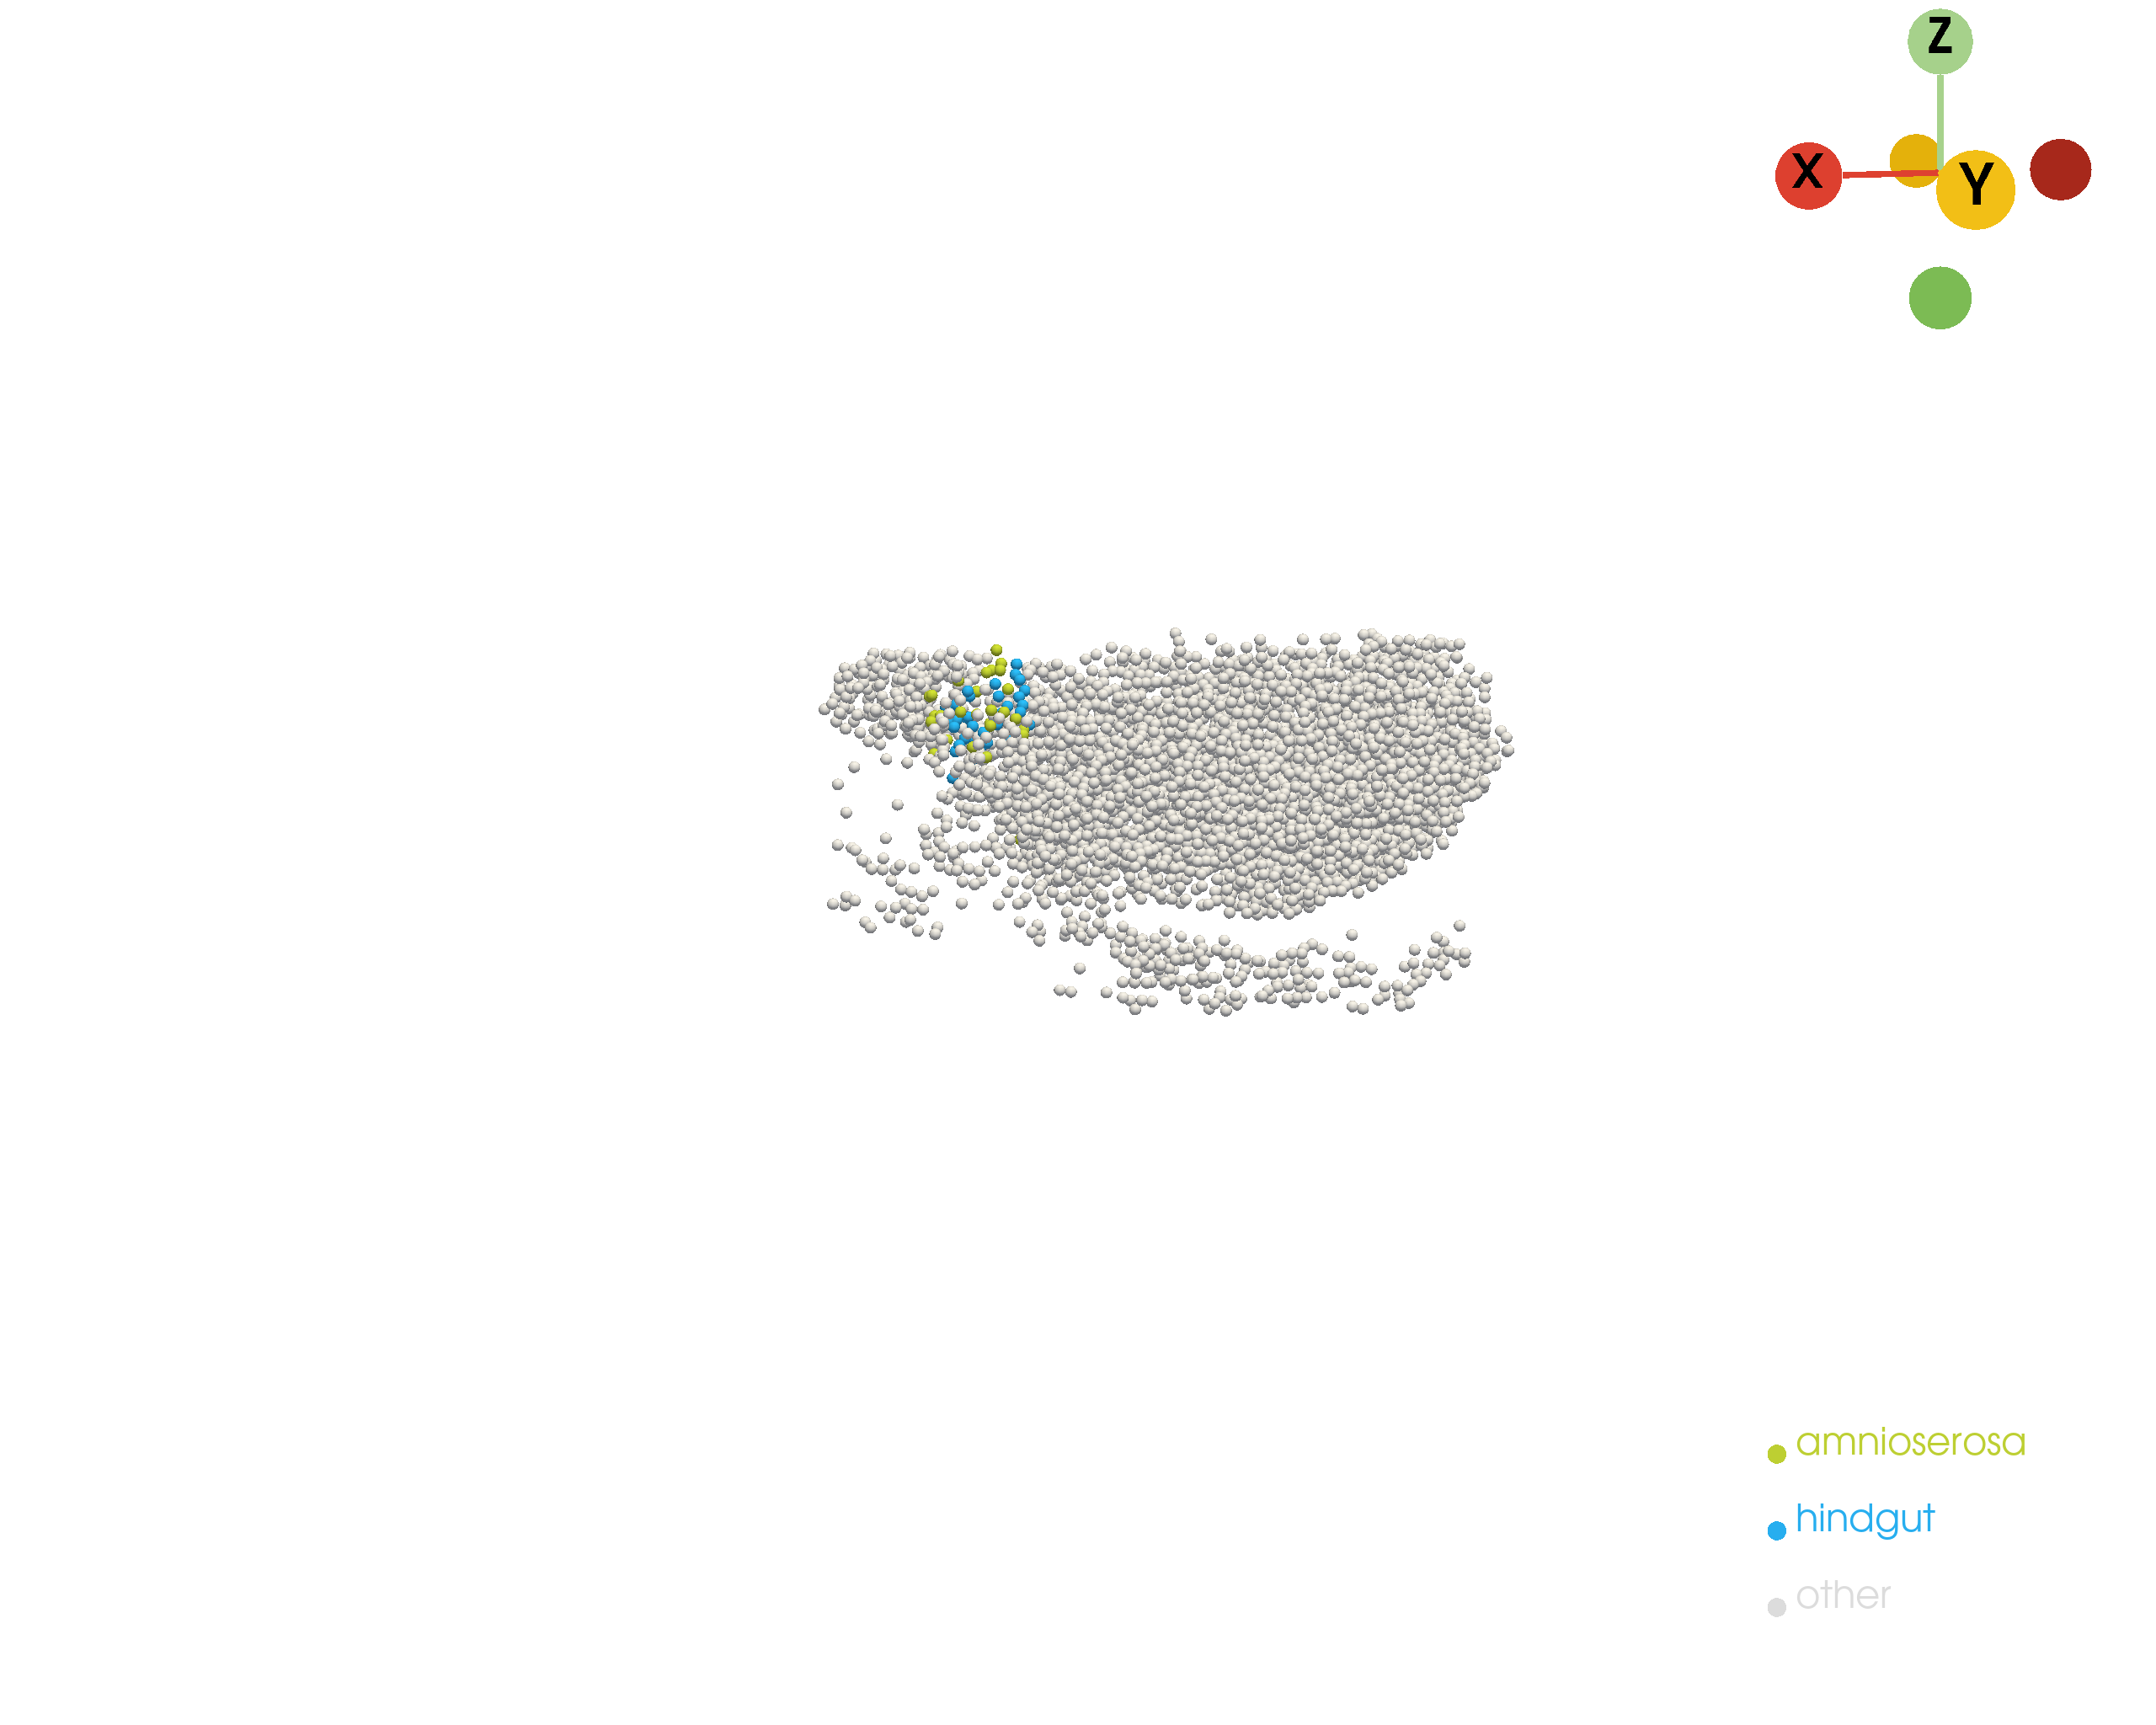

In [79]:
st.tl.prepare_cci_cellpair_adata(
    adata, sender_group=sender_ct, receiver_group=receptor_ct, cci_dict=res, all_cell_pair=False)

pc_index=germ_pc.point_data["obs_index"].tolist()
mmvalue = adata[pc_index, :].obs["spec"].values
st.tdr.add_model_labels(model=germ_pc, labels=mmvalue, key_added="spec", where="point_data",inplace=True, colormap={"hindgut": "#27aeef", "amnioserosa": "#bdcf32", 'other': 'gainsboro'})
st.pl.three_d_plot(
    model=germ_pc,
    key="spec",
    model_style="points",
    model_size=14,
    opacity=1,
    show_legend=True,
    jupyter="static",
    background="white",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}_cci_region.pdf")
)

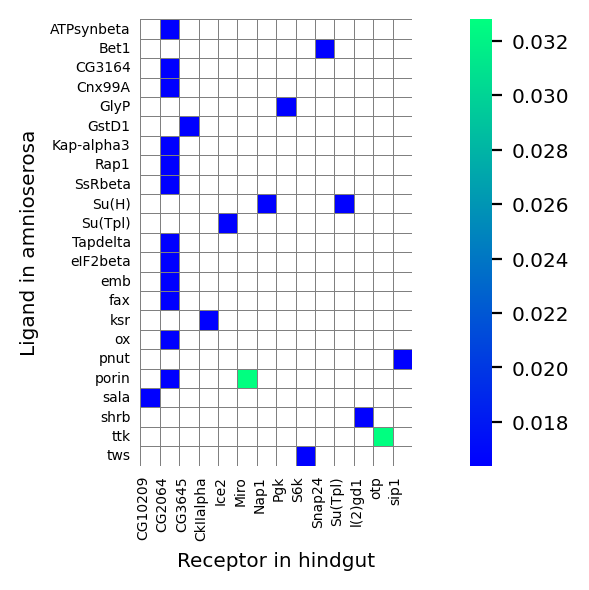

In [80]:
df = res['lr_pair']
df = df.loc[df['lr_co_exp_num'] > 0].sort_values('lr_co_exp_ratio', ascending=False)

lr_data=df.loc[:,["from", "to", "lr_co_exp_ratio"]].pivot(index="from", columns="to", values="lr_co_exp_ratio").fillna(0)
fig = plt.figure()
fig.set_size_inches(6, 3)
x_label=list(lr_data.columns.tolist())
y_label=list(lr_data.index)
ax = sns.heatmap(
    lr_data,
    cmap="winter",
    square=True,
    yticklabels=y_label,
    linecolor='grey',
    linewidths=0.3,
    annot_kws={'size':9,'weight':'bold',},
    xticklabels=x_label,
    mask=(lr_data<0.001)
)
plt.gcf().subplots_adjust(bottom=0.3)
plt.xlabel(f"Receptor in {receptor_ct}")
plt.ylabel(f"Ligand in {sender_ct}")
ax.set_xticklabels(x_label, rotation=90, ha="right", fontsize=5,)
ax.set_yticklabels(y_label, rotation=0, ha="right", fontsize=5,)
plt.tick_params(axis='both', length=0)
plt.tight_layout()
plt.savefig(os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}_cci_heatmap.pdf"), transparent=True)

## Muscle and midgut

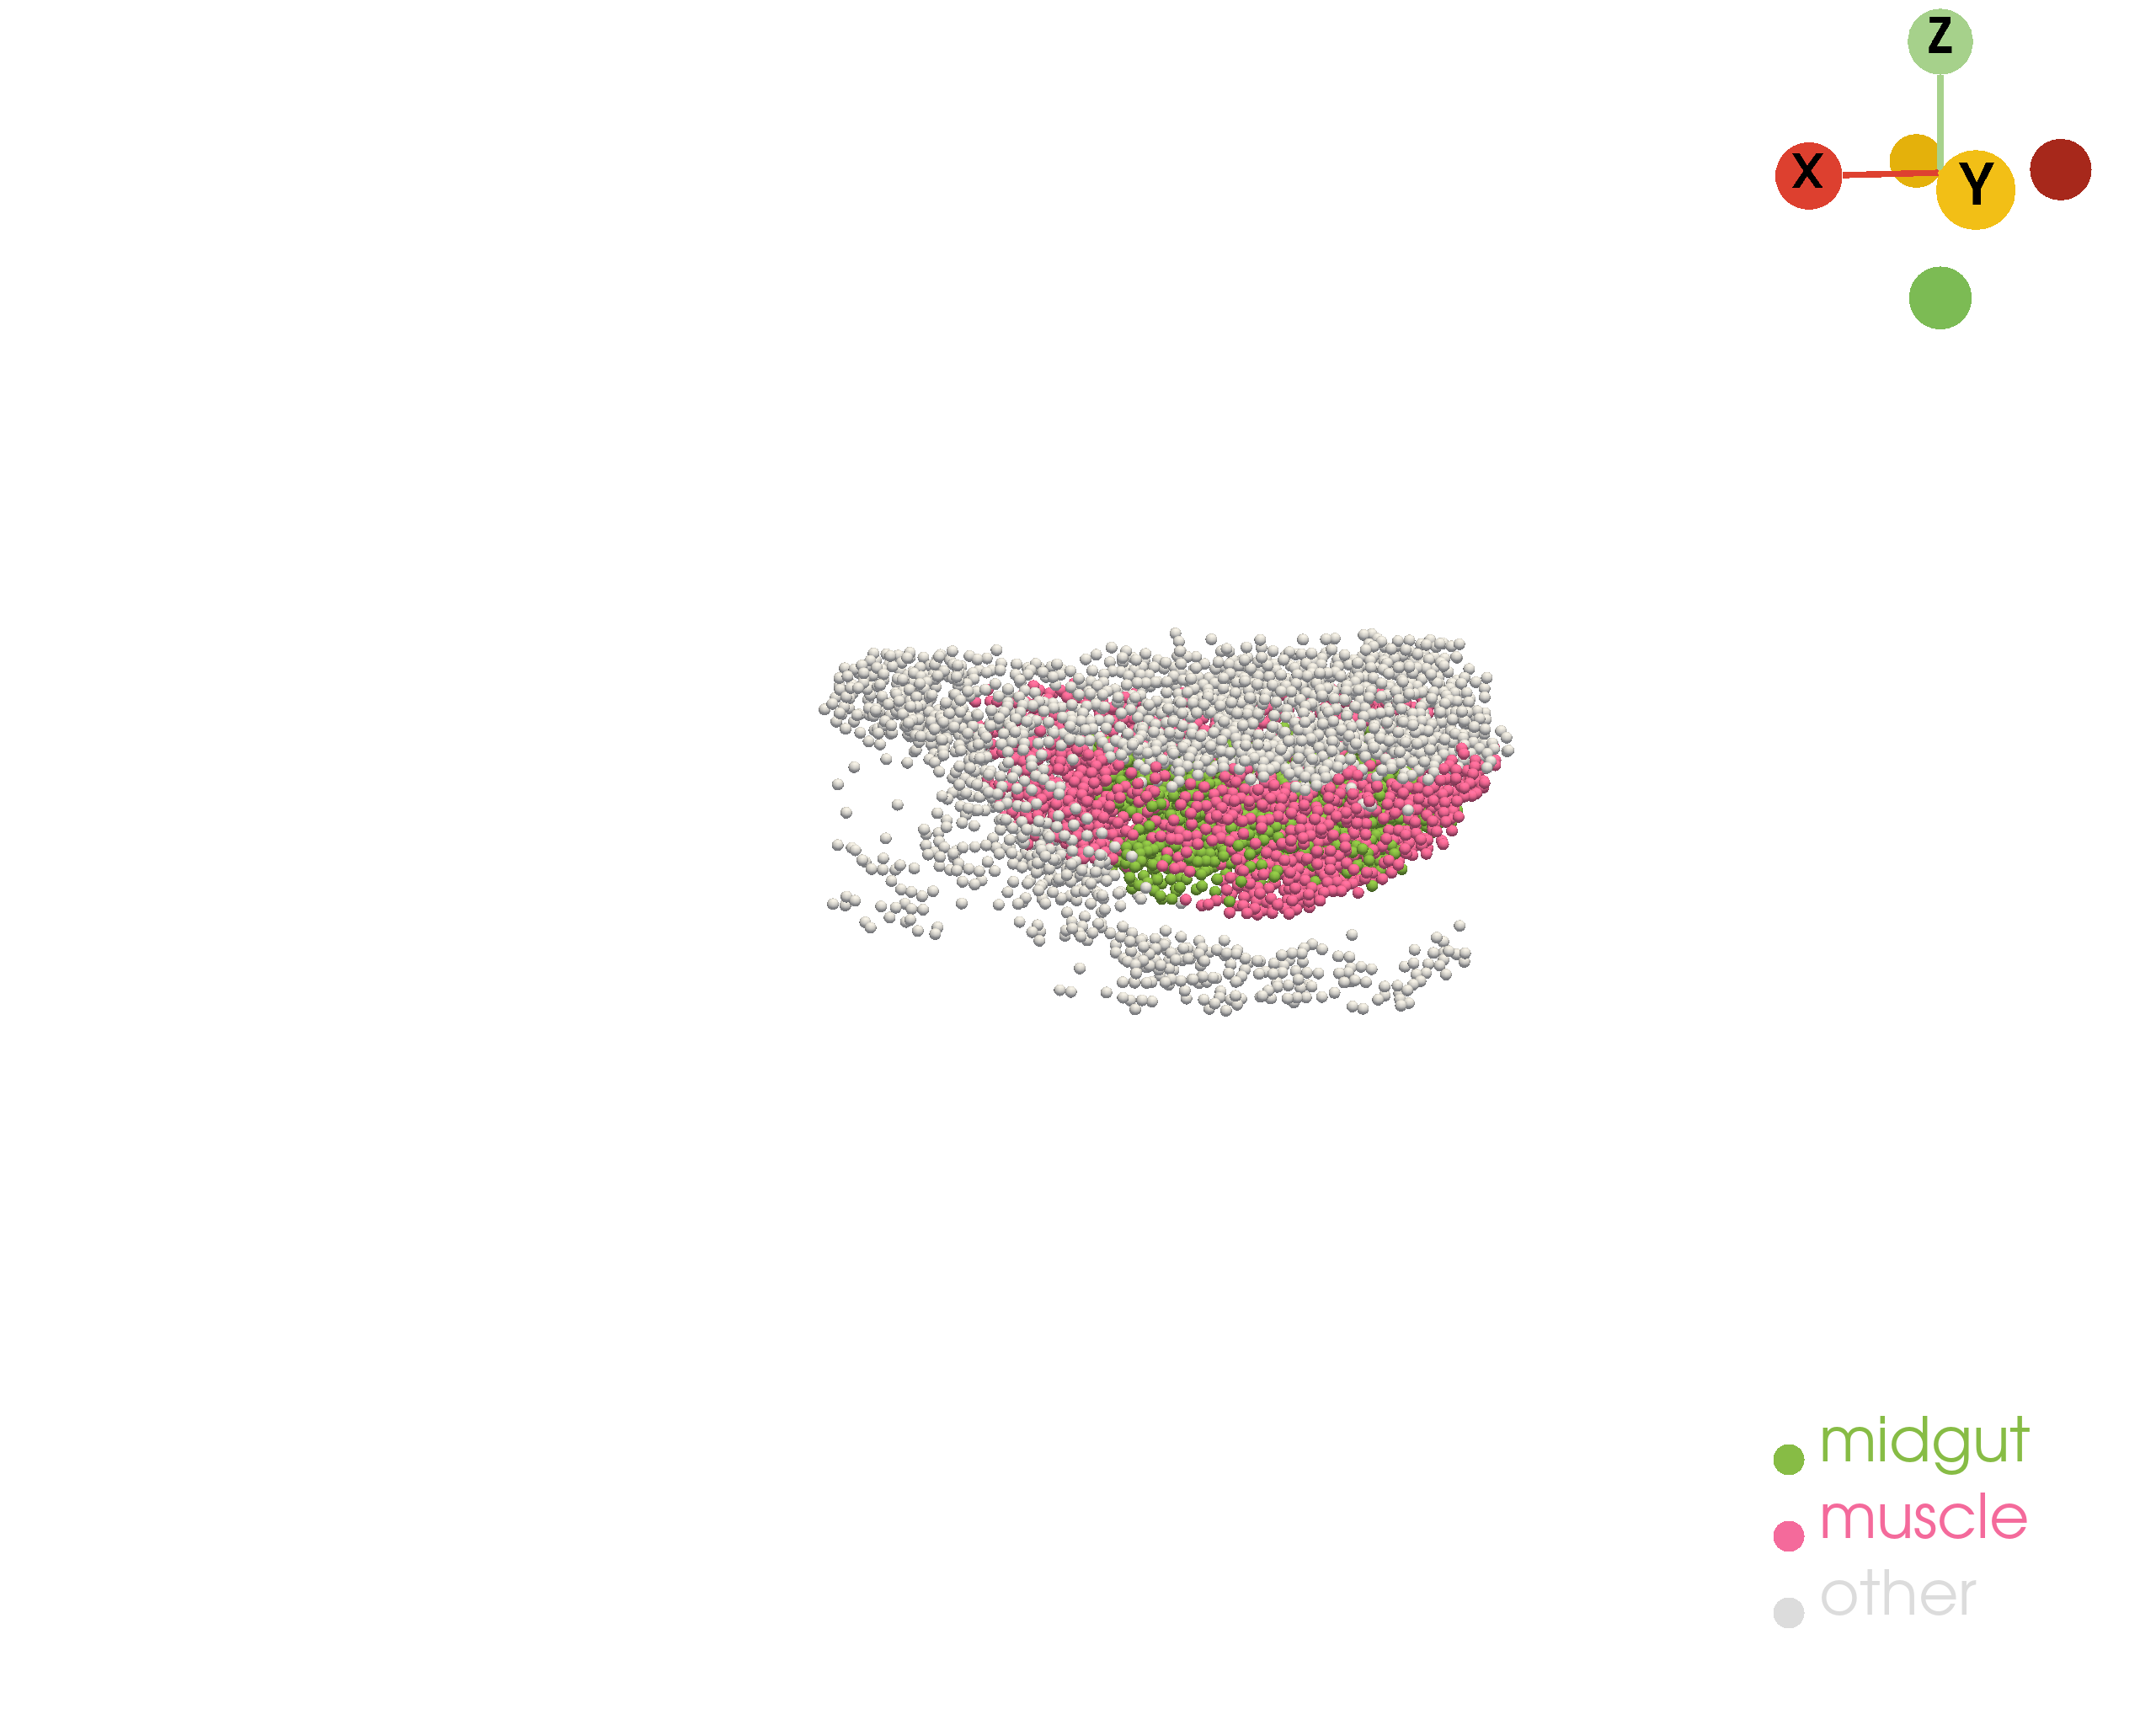

In [81]:
sender_ct, receptor_ct = "muscle", "midgut"
st.tl.prepare_cci_cellpair_adata(
    adata, sender_group=sender_ct, receiver_group=receptor_ct, group='anno_tissue_new', all_cell_pair=True
)
# plot all cell pair
pc_index=germ_pc.point_data["obs_index"].tolist()
mmvalue = adata[pc_index, :].obs["spec"].values
st.tdr.add_model_labels(model=germ_pc, labels=mmvalue, key_added="spec", where="point_data",inplace=True, colormap={"hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", 'other': 'gainsboro'})
    
st.pl.three_d_plot(
    model=germ_pc,
    key="spec",
    model_style="points",
    model_size=14,
    opacity=1,
    show_legend=True,
    jupyter="static",
    background="white",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}.pdf")
)


In [83]:
res = st.tl.find_cci_two_group(adata,
                               path="/home/pc001/BioProjects/Packages/spateo-release/spateo/tools/database/",
                               species='drosophila',
                               group='anno_tissue_new',
                               sender_group=sender_ct,
                               receiver_group=receptor_ct,
                               filter_lr='outer',
                               mode="mode2",
                               fdr=True,
                               min_pairs=0,
                               min_pairs_ratio=0,
                               top=50,)

|-----> 50 ligands for cell type muscle_prox with highest fraction of prevalence: ['otu', 'vkg', 'spz', 'upd1', 'mael', 'CG3085', 'Pka-R2', 'ZIPIC', 'ato', 'Mlc1', 'CG17118', 'erm', 'HLH54F', 'Reg-2', 'bin', 'tin', 'Hand', 'Nost', 'H2.0', 'mwh', 'mei-9', 'FLASH', 'blow', 'side-IV', 'scpr-C', 'Vlet', 'CG8507', 'CG10863', 'sls', 'CG2662', 'CG3407', 'CG1603', 'Atg101', 'CG4854', 'tx', 'sns', 'vn', 'Vps51', 'CG4860', 'flw', 'CG9689', 'ECSIT', 'APP-BP1', 'Cpr78E', 'sstn', 'CG4407', 'grnd', 'Grip75', 'CG5009', 'RluA-2']. Testing interactions involving these genes.
|-----> 50 receptors for cell type midgut_prox with highest fraction of prevalence: ['Hexo1', 'GstD9', 'Brca2', 'CG11700', 'Rbsn-5', 'CG17806', 'Bdbt', 'tll', 'CG7737', 'CG10026', 'CG3726', 'prd', 'Mlc1', 'Pbp95', 'CG18596', 'Rad1', 'trol', 'az2', 'Vps16B', 'vas', 'park', 'CG31729', 'GstT1', 'DNAlig4', 'CG4407', 'sw', 'yip2', 'mthl5', 'CG4730', 'CG4294', 'mst', 'Sply', 'slam', 'melt', 'del', 'kek2', 'kek6', 'CG17802', 'serp', 'CG31

100%|██████████| 1000/1000 [00:05<00:00, 179.59it/s]


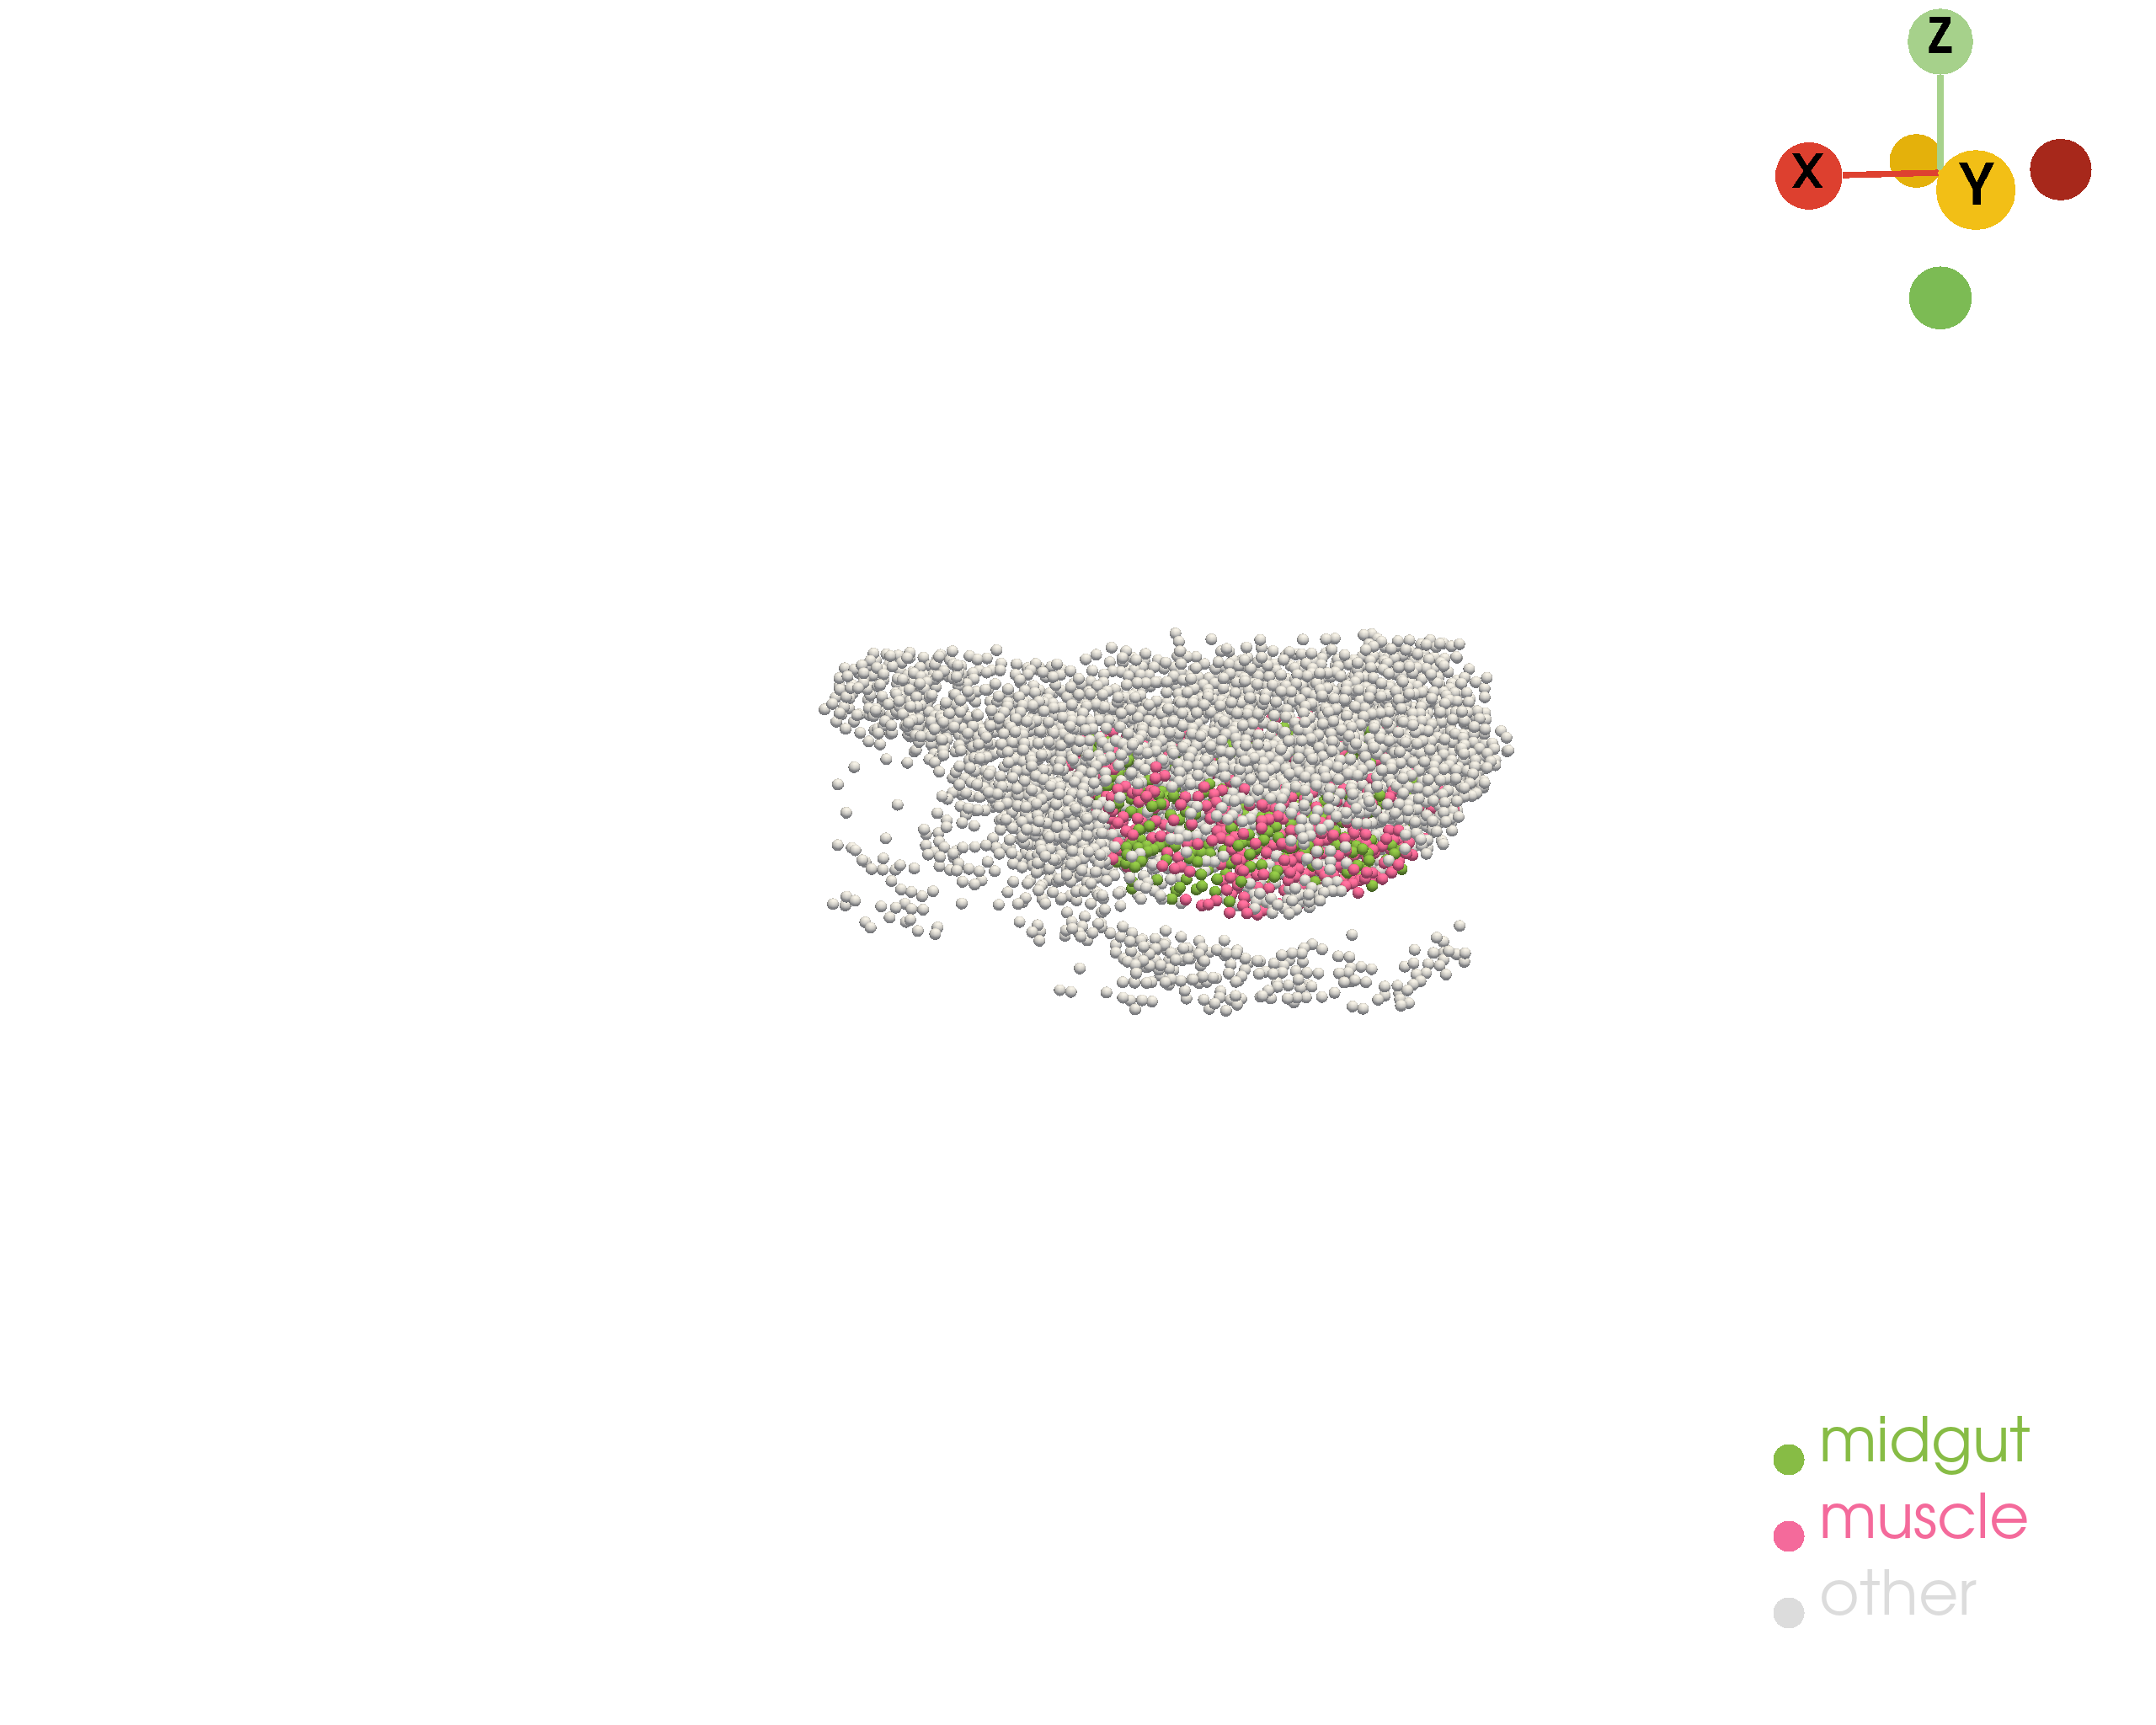

In [84]:
st.tl.prepare_cci_cellpair_adata(
    adata, sender_group=sender_ct, receiver_group=receptor_ct, cci_dict=res, all_cell_pair=False)

pc_index=germ_pc.point_data["obs_index"].tolist()
mmvalue = adata[pc_index, :].obs["spec"].values
st.tdr.add_model_labels(model=germ_pc, labels=mmvalue, key_added="spec", where="point_data",inplace=True, colormap={"hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", 'other': 'gainsboro'})
st.pl.three_d_plot(
    model=germ_pc,
    key="spec",
    model_style="points",
    model_size=14,
    opacity=1,
    show_legend=True,
    jupyter="static",
    background="white",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}_cci_region.pdf")
)

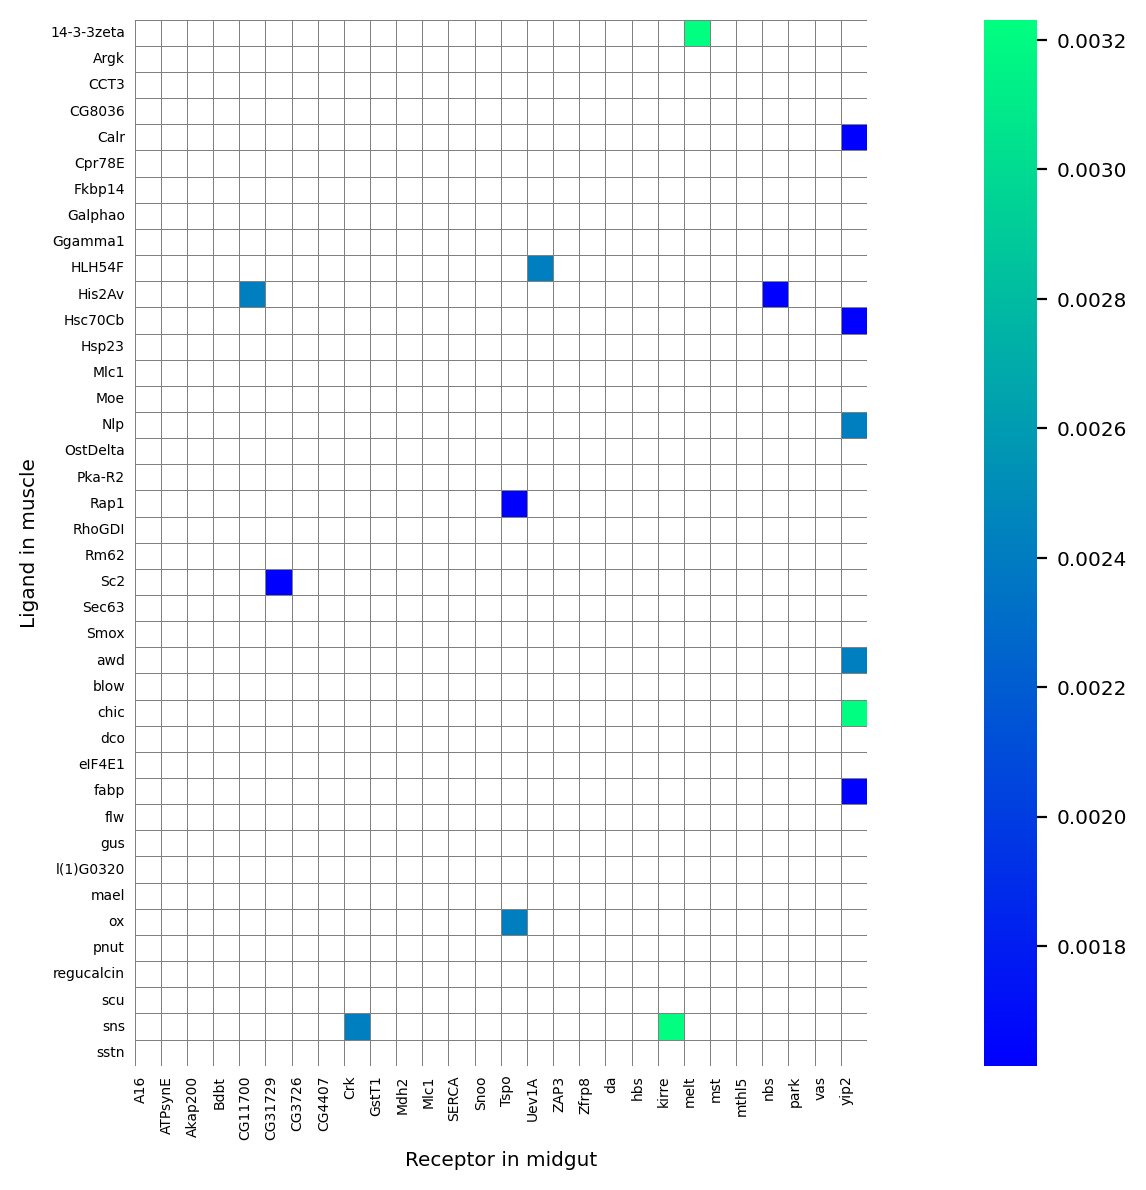

In [85]:
df = res['lr_pair']
df = df.loc[df['lr_co_exp_num'] > 0].sort_values('lr_co_exp_ratio', ascending=False)

lr_data=df.loc[:,["from", "to", "lr_co_exp_ratio"]].pivot(index="from", columns="to", values="lr_co_exp_ratio").fillna(0)
fig = plt.figure()
fig.set_size_inches(12, 6)
x_label=list(lr_data.columns.tolist())
y_label=list(lr_data.index)
ax = sns.heatmap(
    lr_data,
    cmap="winter",
    square=True,
    yticklabels=y_label,
    linecolor='grey',
    linewidths=0.3,
    annot_kws={'size':9,'weight':'bold',},
    xticklabels=x_label,
    mask=(lr_data<0.001)
)
plt.gcf().subplots_adjust(bottom=0.3)
plt.xlabel(f"Receptor in {receptor_ct}")
plt.ylabel(f"Ligand in {sender_ct}")
ax.set_xticklabels(x_label, rotation=90, ha="right", fontsize=5,)
ax.set_yticklabels(y_label, rotation=0, ha="right", fontsize=5,)
plt.tick_params(axis='both', length=0)
plt.tight_layout()
plt.savefig(os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}_cci_heatmap.pdf"), transparent=True)

## Muscle and hindgut

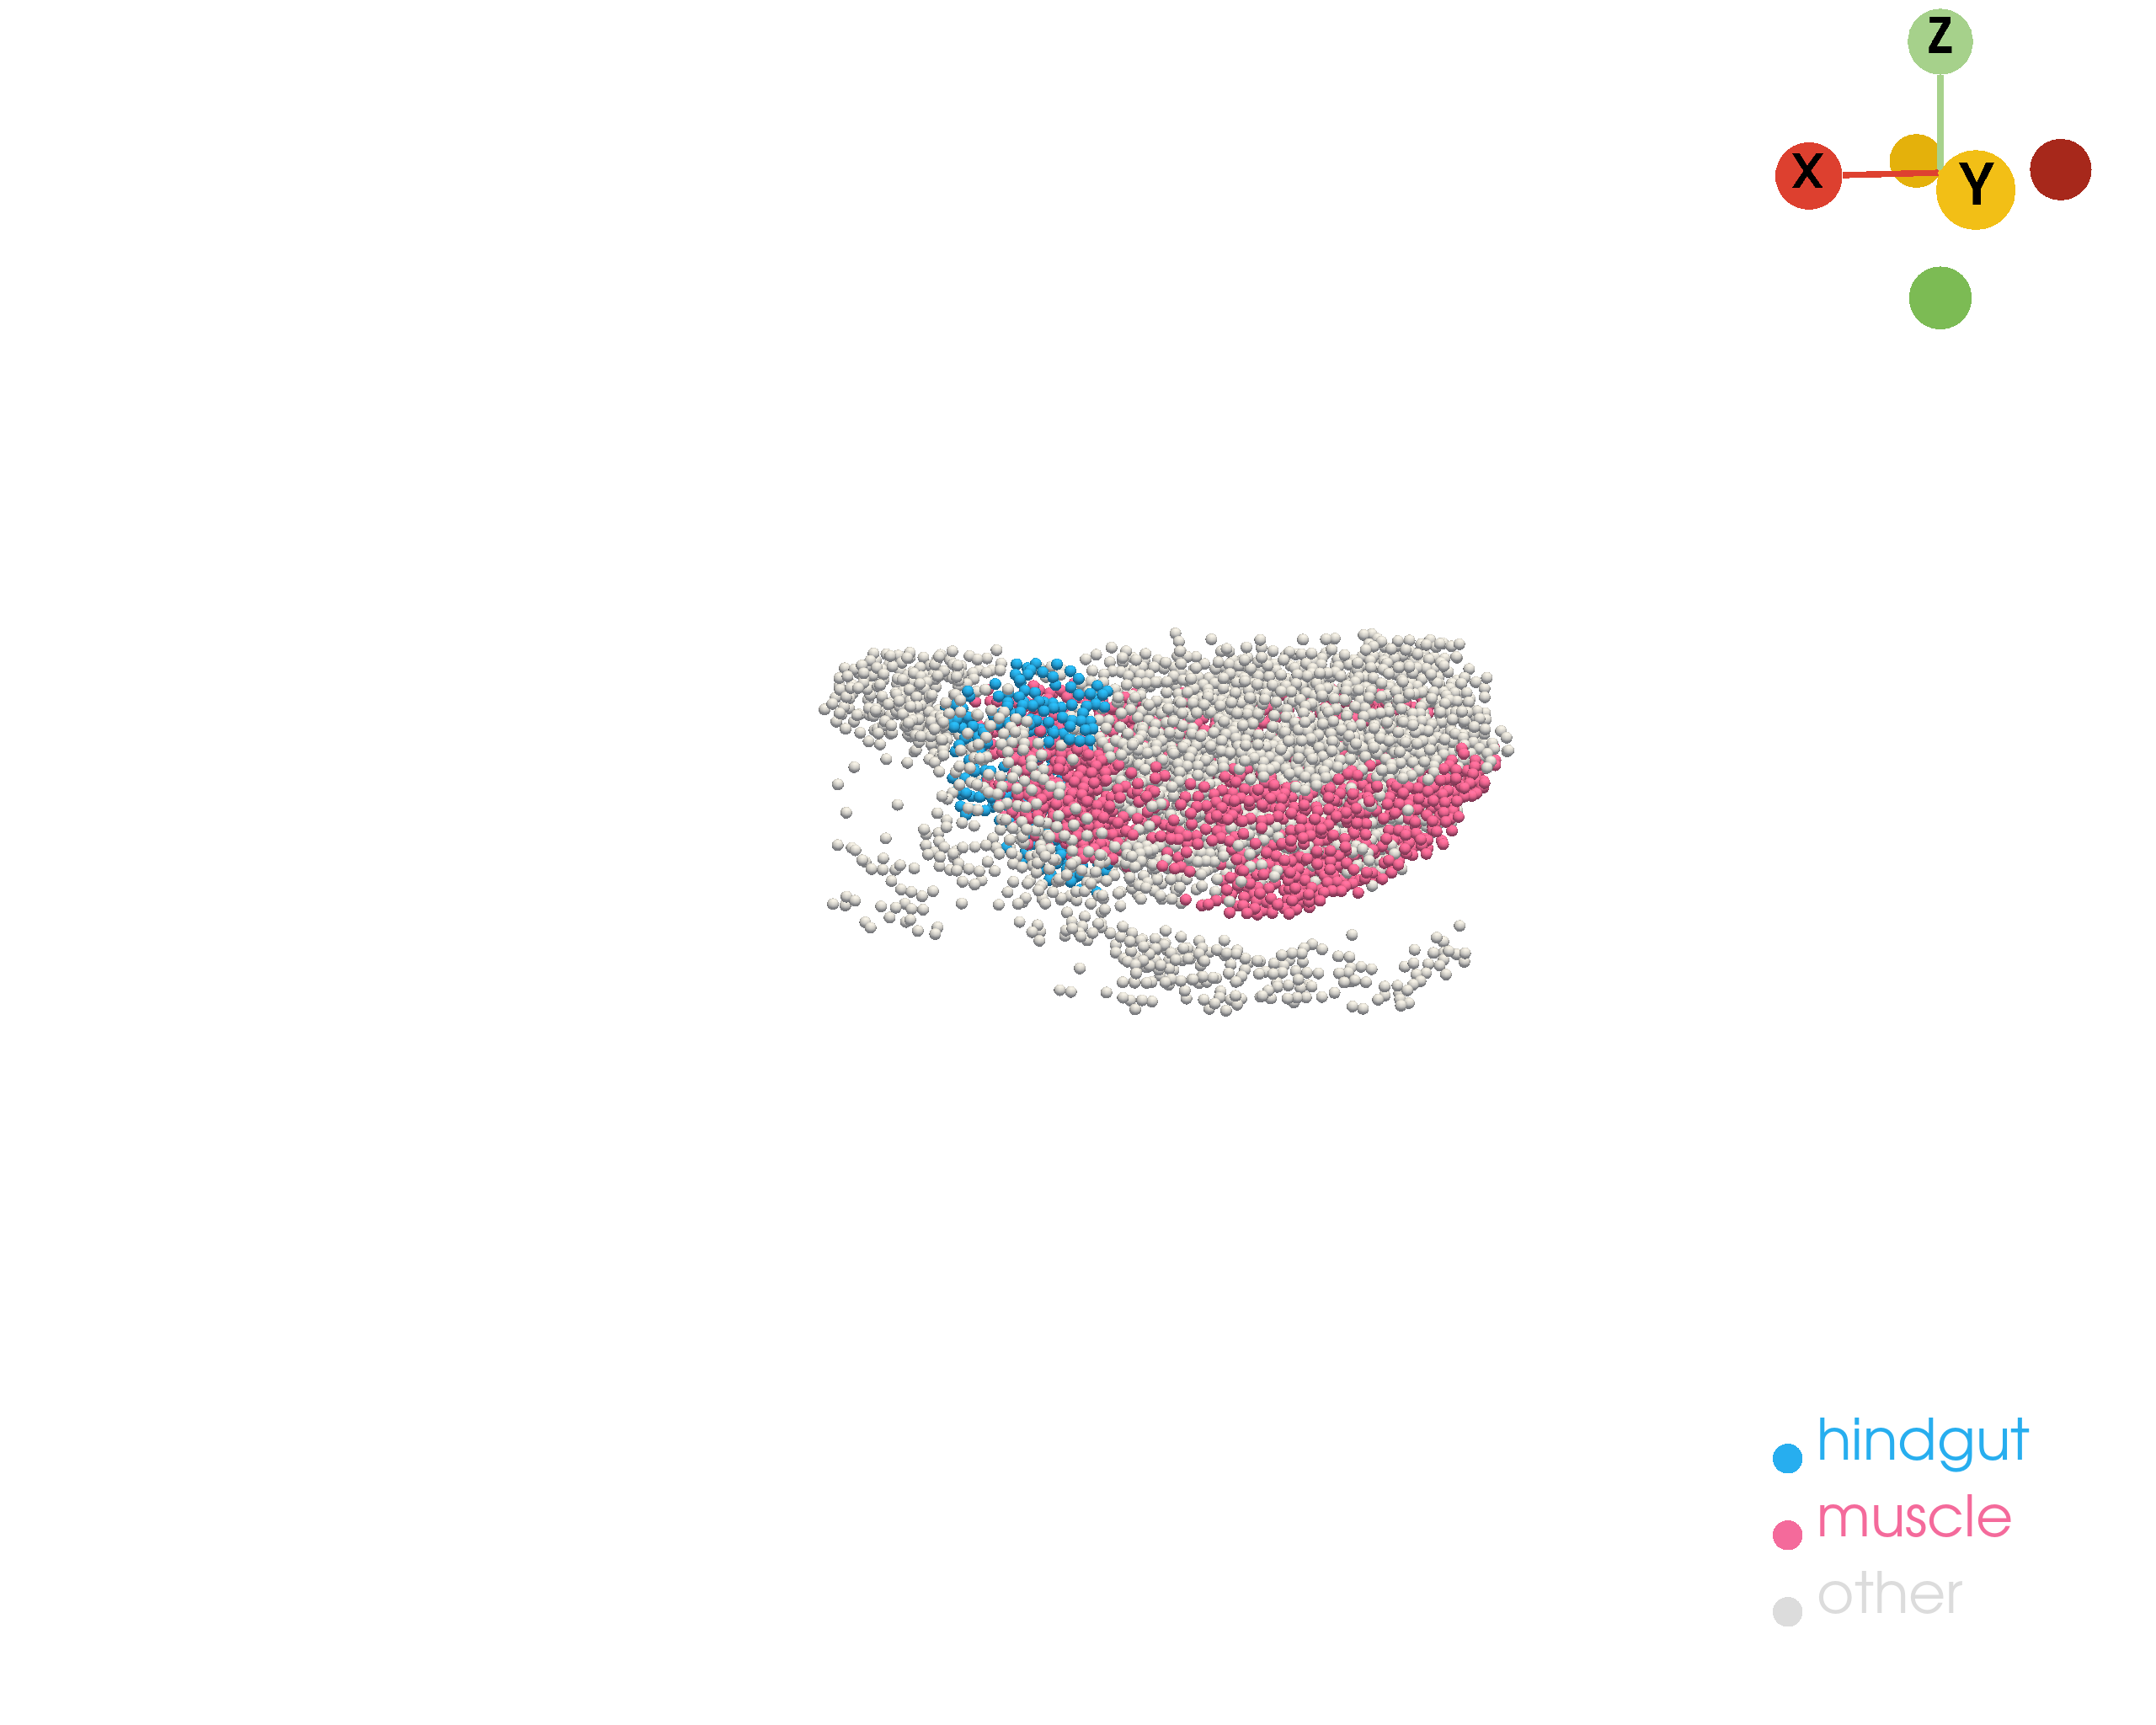

In [86]:
sender_ct, receptor_ct = "muscle", "hindgut"
st.tl.prepare_cci_cellpair_adata(
    adata, sender_group=sender_ct, receiver_group=receptor_ct, group='anno_tissue_new', all_cell_pair=True
)
# plot all cell pair
pc_index=germ_pc.point_data["obs_index"].tolist()
mmvalue = adata[pc_index, :].obs["spec"].values
st.tdr.add_model_labels(model=germ_pc, labels=mmvalue, key_added="spec", where="point_data",inplace=True, colormap={"hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", 'other': 'gainsboro'})
    
st.pl.three_d_plot(
    model=germ_pc,
    key="spec",
    model_style="points",
    model_size=14,
    opacity=1,
    show_legend=True,
    jupyter="static",
    background="white",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}.pdf")
)


In [87]:
res = st.tl.find_cci_two_group(adata,
                               path="/home/pc001/BioProjects/Packages/spateo-release/spateo/tools/database/",
                               species='drosophila',
                               group='anno_tissue_new',
                               sender_group=sender_ct,
                               receiver_group=receptor_ct,
                               filter_lr='outer',
                               mode="mode2",
                               fdr=True,
                               min_pairs=0,
                               min_pairs_ratio=0,
                               top=50,)

|-----> 50 ligands for cell type muscle_prox with highest fraction of prevalence: ['qkr54B', 'CG11275', 'rdgB', 'btv', 'LamC', 'ApepP', 'CG1602', 'lft', 'grk', 'CG9098', 'Tsc1', 'CG8712', 'wash', 'Not11', 'twi', 'Mis12', 'CG4822', 'Dgp-1', 'Keap1', 'Nost', 'fz3', 'Pgd', 'CG4854', 'Spt20', 'Cyp4e2', 'PPO2', 'ac', 'tok', 'mael', 'CG8281', 'CG5599', 'png', 'Bsg25D', 'dgrn', 'aos', 'CG10435', 'CG42557', 'Drp1', 'Tig', 'dgt6', 'Socs16D', 'CG1792', 'Cpr78E', 'Myd88', 'Rab40', 'hh', 'alpha-Man-IIa', 'CG5953', 'HPS1', 'CG13319']. Testing interactions involving these genes.
|-----> 50 receptors for cell type hindgut_prox with highest fraction of prevalence: ['CG6726', 'Vps39', 'otp', 'CG7692', 'Vps52', 'AP-1gamma', 'CG12320', 'CYLD', 'Pex5', 'Tbc1d15-17', 'PPO1', 'Klp64D', 'jet', 'Asciz', 'CG30377', 'Awh', 'Uba3', 'tej', 'FAM21', 'Ccs', 'CG33156', 'X11L', 'Gsc', 'CG32549', 'nxf2', 'Alk', 'jnj', 'fray', 'Not10', 'Mt2', 'Rbp6', 'iPLA2-VIA', 'Atf3', 'ap', 'CG16959', 'Ack', 'Sox21b', 'CG11275', 'eI

100%|██████████| 1000/1000 [00:03<00:00, 260.86it/s]


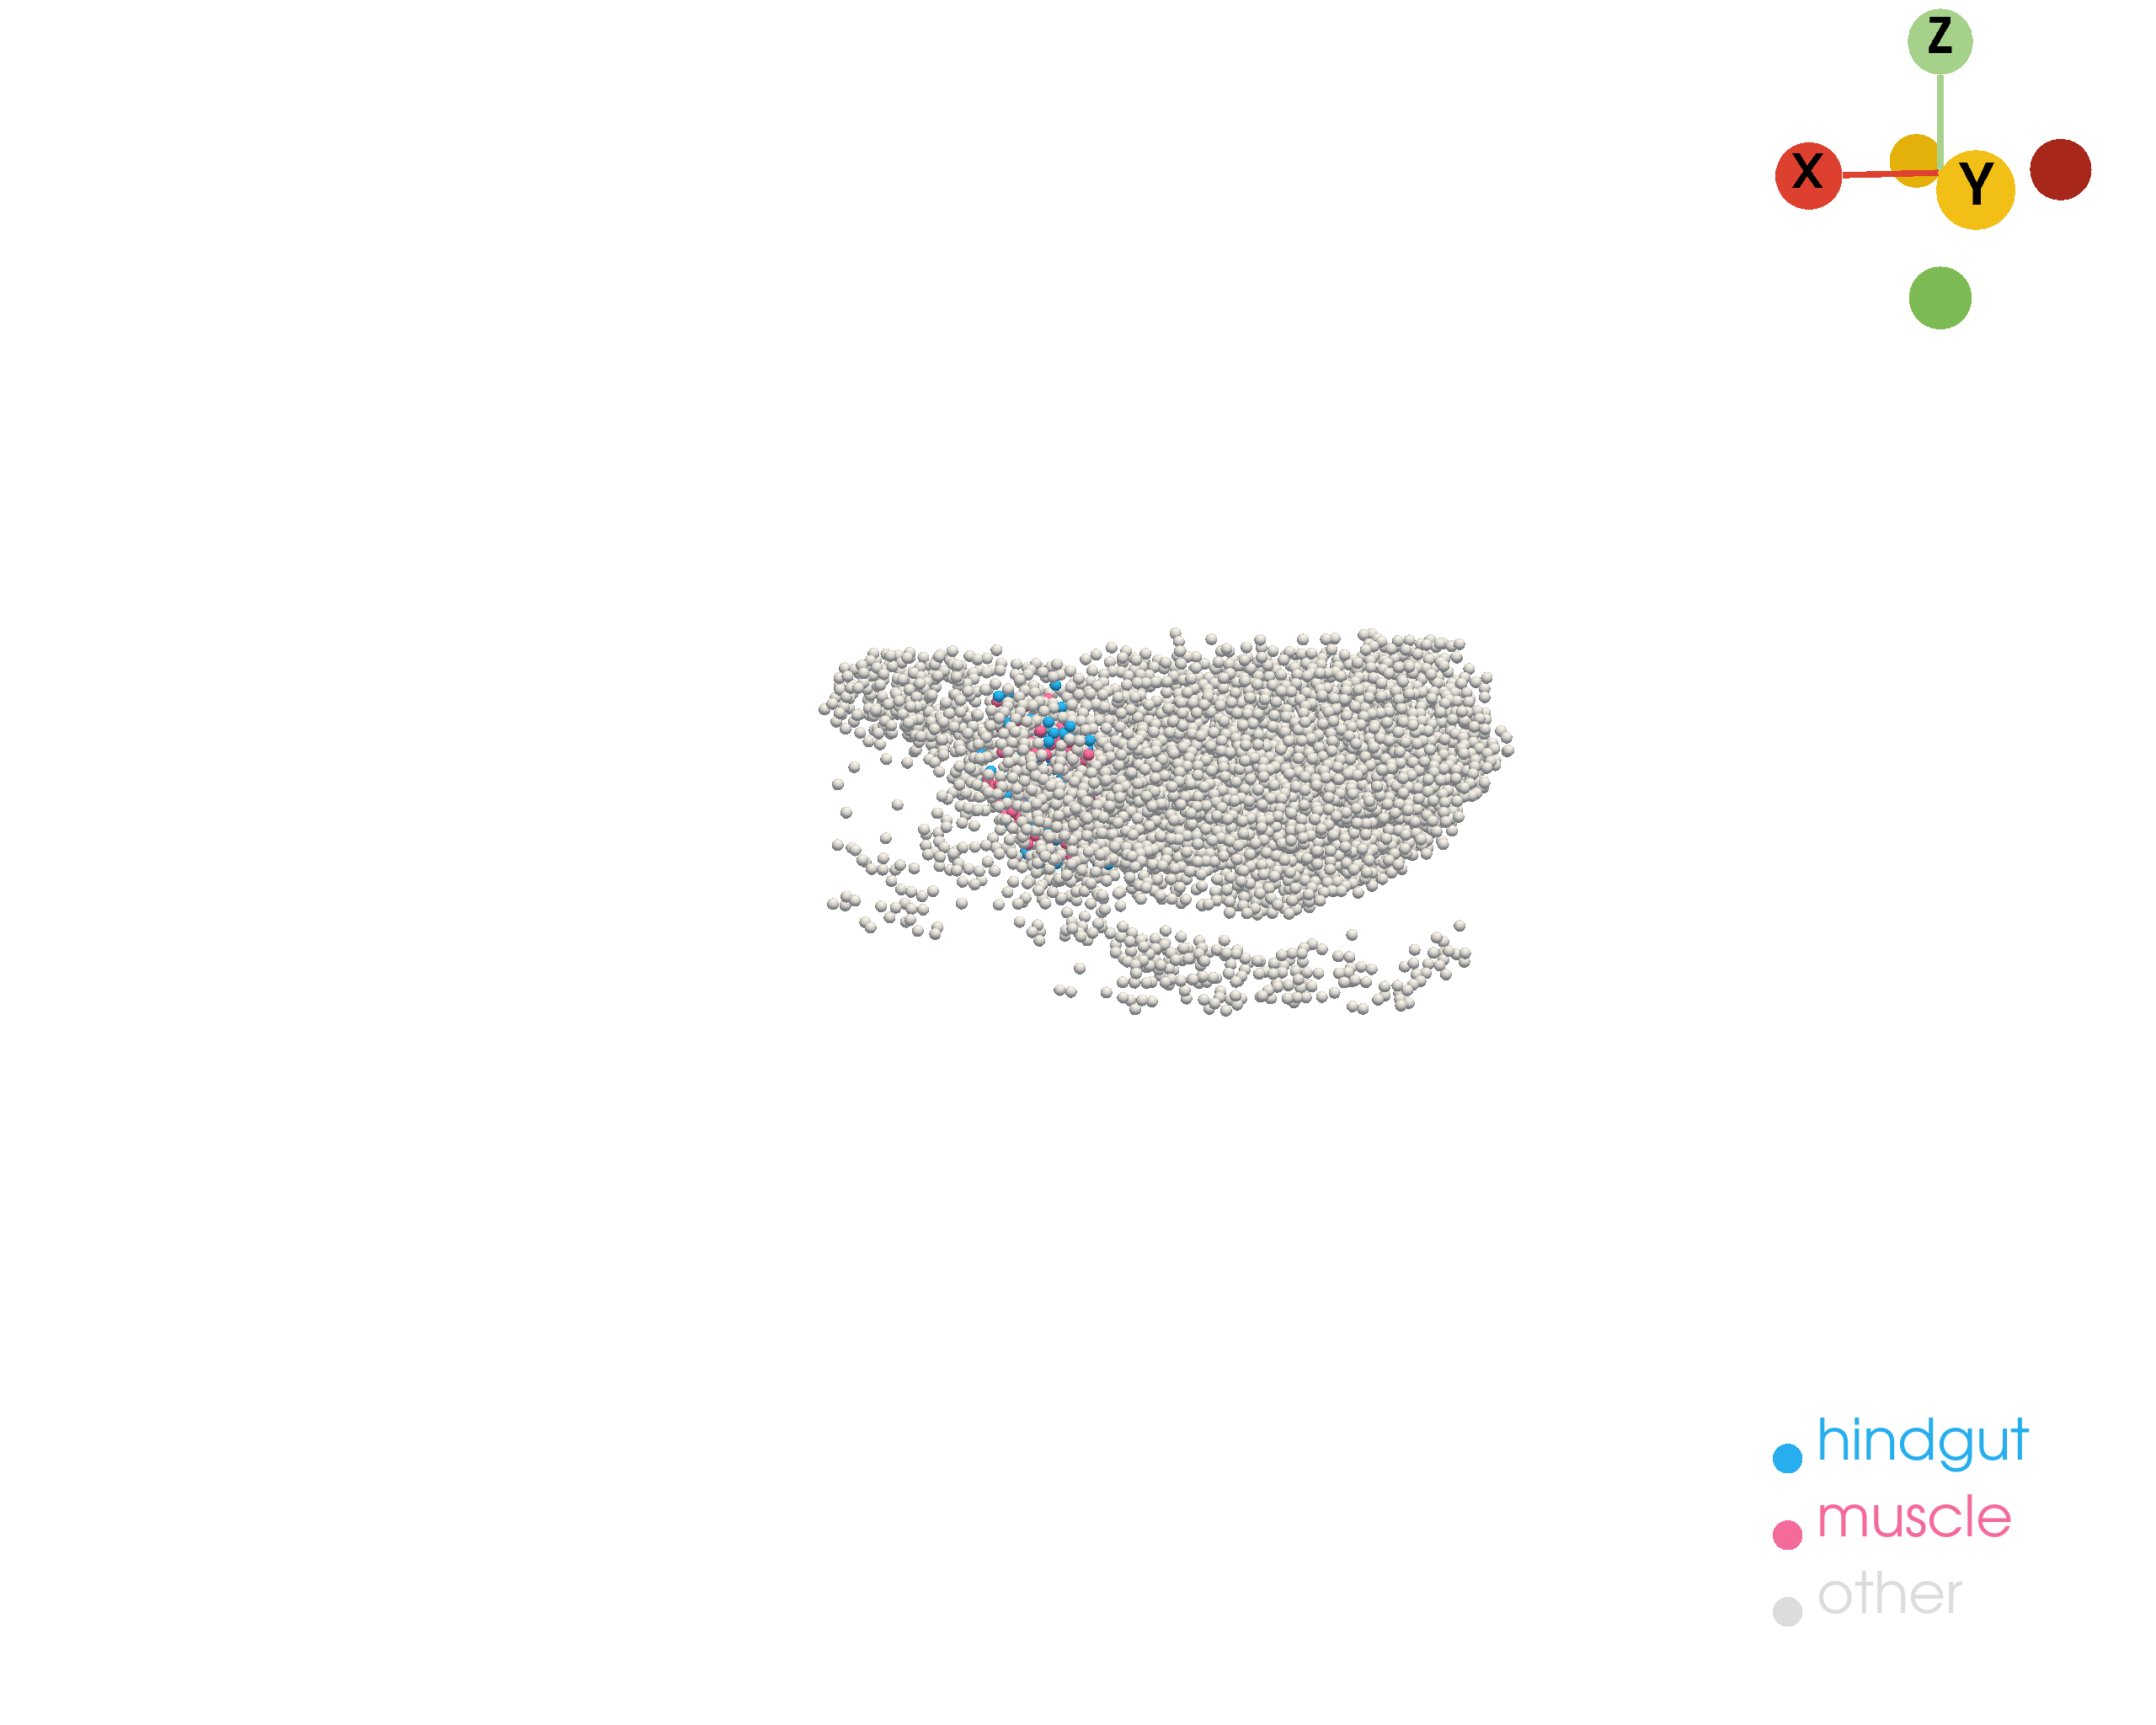

In [88]:
st.tl.prepare_cci_cellpair_adata(
    adata, sender_group=sender_ct, receiver_group=receptor_ct, cci_dict=res, all_cell_pair=False)

pc_index=germ_pc.point_data["obs_index"].tolist()
mmvalue = adata[pc_index, :].obs["spec"].values
st.tdr.add_model_labels(model=germ_pc, labels=mmvalue, key_added="spec", where="point_data",inplace=True, colormap={"hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", 'other': 'gainsboro'})
st.pl.three_d_plot(
    model=germ_pc,
    key="spec",
    model_style="points",
    model_size=14,
    opacity=1,
    show_legend=True,
    jupyter="static",
    background="white",
    cpo=cpo,
    window_size=(2560, 2048),
    filename=os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}_cci_region.pdf")
)

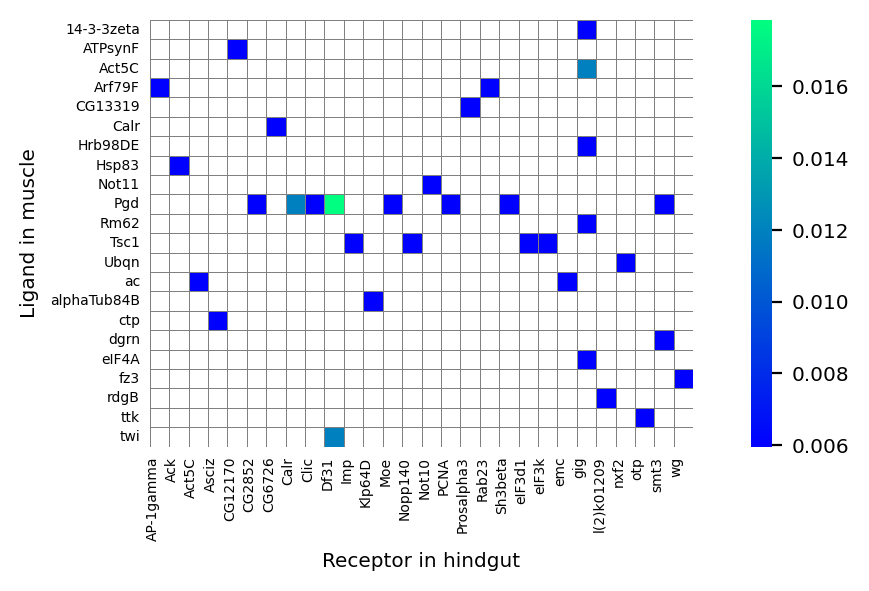

In [89]:
df = res['lr_pair']
df = df.loc[df['lr_co_exp_num'] > 0].sort_values('lr_co_exp_ratio', ascending=False)

lr_data=df.loc[:,["from", "to", "lr_co_exp_ratio"]].pivot(index="from", columns="to", values="lr_co_exp_ratio").fillna(0)
fig = plt.figure()
fig.set_size_inches(6, 3)
x_label=list(lr_data.columns.tolist())
y_label=list(lr_data.index)
ax = sns.heatmap(
    lr_data,
    cmap="winter",
    square=True,
    yticklabels=y_label,
    linecolor='grey',
    linewidths=0.3,
    annot_kws={'size':9,'weight':'bold',},
    xticklabels=x_label,
    mask=(lr_data<0.001)
)
plt.gcf().subplots_adjust(bottom=0.3)
plt.xlabel(f"Receptor in {receptor_ct}")
plt.ylabel(f"Ligand in {sender_ct}")
ax.set_xticklabels(x_label, rotation=90, ha="right", fontsize=5,)
ax.set_yticklabels(y_label, rotation=0, ha="right", fontsize=5,)
plt.tick_params(axis='both', length=0)
plt.tight_layout()
plt.savefig(os.path.join(out_image_path, f"{sample_id}_{sender_ct}_{receptor_ct}_cci_heatmap.pdf"), transparent=True)